In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys, os
import MySQLdb
sys.path.append(os.path.abspath("..")) 
from IPython.display import display
from tabulate import tabulate
import matplotlib.dates as mdates


### **Get DATA from SQL**

In [4]:
conn = MySQLdb.connect(
    host='127.0.0.1',
    port=3333,
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASSWORD"),
    db=os.getenv("DB_NAME")
)

cards_df = pd.read_sql("SELECT * FROM cards WHERE game = 26", conn)
sales_df = pd.read_sql("SELECT * FROM market_sales", conn)

df_26 = sales_df.merge(cards_df, on='card_id', how='left')

df_26 = df_26.sort_values('sale_time', ascending=False)

conn.close()

C:\Users\shane\AppData\Local\Temp\ipykernel_8304\2421375848.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cards_df = pd.read_sql("SELECT * FROM cards WHERE game = 26", conn)
C:\Users\shane\AppData\Local\Temp\ipykernel_8304\2421375848.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_df = pd.read_sql("SELECT * FROM market_sales", conn)


### **Dip Buy / Mean Reversion Strategy**

In [5]:
# ===============================
# 📊 Dip Detector Configuration
# ===============================
SHORT_HOURS = 6
LONG_HOURS = 16
SHORT_TRADES = 20
LONG_TRADES = 100
MIN_SHORT_SALES = 15
MIN_LONG_SALES = 40

# ===============================
# 📊 Dynamic Thresholds
# ===============================
def get_thresholds(price):
    if price >= 200_000:       # elite cards
        return 3, 5            # MEDIUM=3%, HIGH=5%
    elif price >= 50_000:      # mid-tier cards
        return 5, 8
    else:                      # cheap fodder
        return 10, 14

# ===============================
# 📊 Dip Detection Logic
# ===============================
platforms = ["pc", "ps"]

for plat in platforms:
    print(f"\n===== 📊 Platform: {plat.upper()} =====\n")

    cutoff_short = df_26['sale_time'].max() - pd.Timedelta(hours=SHORT_HOURS)
    cutoff_long = df_26['sale_time'].max() - pd.Timedelta(hours=LONG_HOURS)

    short_df = df_26[
        (df_26['sale_time'] > cutoff_short) &
        (df_26['platform'] == plat) &
        (df_26['sold_price'] > 0) 
    ]

    long_df = df_26[
        (df_26['sale_time'] > cutoff_long) &
        (df_26['platform'] == plat) &
        (df_26['sold_price'] > 0) 
    ]

    buy_candidates = []

    for card_id, group in short_df.groupby('card_id'):
        group = group.sort_values('sale_time', ascending=False)

        if len(group) >= MIN_SHORT_SALES:
            # Short-term avg
            last_short_avg = group.head(SHORT_TRADES)['sold_price'].mean()

            # Long-term avg
            long_group = long_df[long_df['card_id'] == card_id].sort_values('sale_time', ascending=False)
            if len(long_group) < MIN_LONG_SALES:
                continue

            last_long_avg = long_group.head(LONG_TRADES)['sold_price'].mean()
            sales_volume = len(long_group)

            # Calculate drop %
            drop_pct = (last_long_avg - last_short_avg) / last_long_avg * 100
            if last_short_avg < 5000:  # skip unusable cards
                continue

            # Dynamic thresholds
            low, high = get_thresholds(last_long_avg)

            if drop_pct >= high:
                rating = "🔥 High"
            elif drop_pct >= low:
                rating = "⚡ Medium"
            else:
                continue  # skip if not a big enough dip

            # Suggested prices
            buy_price = round(last_short_avg * 0.97)   # buy a bit below short avg
            raw_sell_price = round(last_long_avg * 0.98)  # sell a bit below long avg

            # Apply EA 5% tax
            sell_price_after_tax = int(raw_sell_price * 0.95)

            potential_profit = sell_price_after_tax - buy_price
            profit_margin_pct = (potential_profit / buy_price) * 100

            buy_candidates.append({
                "name": group.iloc[0]["name"],
                "last_short_avg": round(last_short_avg, 2),
                "last_long_avg": round(last_long_avg, 2),
                "drop_%": round(drop_pct, 2),
                "sales_volume": sales_volume,
                "suggested_buy": buy_price,
                "suggested_sell_raw": raw_sell_price,   # before tax
                "suggested_sell_after_tax": sell_price_after_tax,
                "potential_profit": potential_profit,
                "profit_margin_%": round(profit_margin_pct, 2),
                "investment_rating": rating
            })


    # Convert to DataFrame
    buy_df = pd.DataFrame(buy_candidates)

    if not buy_df.empty:
        buy_df = buy_df.sort_values(["investment_rating", "drop_%"], ascending=[False, False])
        print("🔥 Potential Buy Candidates with Ratings 🔥")
        print(tabulate(buy_df.head(20), headers="keys", tablefmt="pretty", showindex=False))
    else:
        print("No buy candidates found with current filters.")



===== 📊 Platform: PC =====

🔥 Potential Buy Candidates with Ratings 🔥
+---------------+----------------+---------------+--------+--------------+---------------+--------------------+--------------------------+------------------+-----------------+-------------------+
|     name      | last_short_avg | last_long_avg | drop_% | sales_volume | suggested_buy | suggested_sell_raw | suggested_sell_after_tax | potential_profit | profit_margin_% | investment_rating |
+---------------+----------------+---------------+--------+--------------+---------------+--------------------+--------------------------+------------------+-----------------+-------------------+
| Diego Milito  |   144944.44    |   153000.0    |  5.27  |      55      |    140596     |       149940       |          142443          |       1847       |      1.31       |     ⚡ Medium     |
| Wendie Renard |    173150.0    |   182582.28   |  5.17  |      79      |    167956     |       178931       |          169984          |       2

### Rising Cards Detector

In [6]:
platforms = ["pc", "ps"]  # you can add "xbox" later if needed

for plat in platforms:
    print(f"\n===== 📊 Platform: {plat.upper()} =====\n")

    recent_df = df_26[
        (df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(hours=12)) 
        & (df_26['sold_price'] > 0) 
        & (df_26['platform'] == plat)
        & (df_26['version'] == "Gold Rare")
    ]

    rising_candidates = []

    for card_id, group in recent_df.groupby('card_id'):
        group = group.sort_values('sale_time', ascending=False)
        
        if len(group) >= 60:  # need enough sales for comparison
            last_short_avg = group.head(10)['sold_price'].mean()  # short-term average
            last_long_avg = group.head(200)['sold_price'].mean()   # longer-term average

            sales_volume = group.shape[0]

            # Check slow rise & liquidity
            if last_short_avg > 1.05 * last_long_avg and sales_volume >= 20:  # 5%+ rise
                suggested_buy = round(last_short_avg * 0.99)  # buy slightly below current price
                suggested_sell = round(last_short_avg * 1.03) # sell slightly above
                potential_profit = suggested_sell - suggested_buy
                rise_percent = (last_short_avg - last_long_avg) / last_long_avg * 100

                # --- Investment Rating ---
                if rise_percent >= 15 and (potential_profit / suggested_buy) * 100 >= 5 and sales_volume >= 30:
                    rating = "🔥 High"
                elif rise_percent >= 10 and (potential_profit / suggested_buy) * 100 >= 3 and sales_volume >= 20:
                    rating = "⚡ Medium"
                else:
                    rating = "⚠️ Low"

                rising_candidates.append({
                    "name": group.iloc[0]["name"],
                    "last_short_avg": round(last_short_avg, 2),
                    "last_long_avg": round(last_long_avg, 2),
                    "rise_%": round(rise_percent, 2),
                    "sales_volume": sales_volume,
                    "suggested_buy": suggested_buy,
                    "suggested_sell": suggested_sell,
                    "potential_profit": potential_profit,
                    "investment_rating": rating
                })
        else:
            continue  # skip cards with too few sales

    # Convert to DataFrame
    rising_df = pd.DataFrame(rising_candidates)

    if not rising_df.empty:
        rising_df = rising_df.sort_values(["investment_rating", "rise_%"], ascending=[False, False])
        print("📈 Potential Slow-Rising Cards 🔥")
        print(rising_df.head(20))
    else:
        print("No slow-rising candidates found with current filters.")



===== 📊 Platform: PC =====

📈 Potential Slow-Rising Cards 🔥
                                name  last_short_avg  last_long_avg  rise_%  \
10                 Emiliano Martinez         15375.0       10735.50   43.22   
15                   Lucas Chevalier          1500.0        1316.25   13.96   
17                 Rosemonde Kouassi          1215.0        1077.86   12.72   
19                        Paul Pogba          1800.0        1615.00   11.46   
18         Jose Diogo Dalot Teixeira          1130.0        1024.25   10.32   
6                   Antonee Robinson          3710.0        3381.50    9.71   
11      Joelinton Apolinario de Lira          1300.0        1186.00    9.61   
16                Racheal Kundananji          1035.0         953.03    8.60   
4                       Milos Kerkez         10920.0       10108.25    8.03   
12             Roger Ibanez da Silva         22225.0       20646.25    7.65   
9                      Heung Min Son          6230.0        5792.50   

### **Low Volatility Sniping Strategy**

In [7]:
# Filter last 24h of sales
recent_df = df_26[(df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(hours=24)) 
                  & (df_26['sold_price'] > 6000) 
                  & (df_26['platform'] == "pc")]

volatility_candidates = []

# Loop through each card
for name, group in recent_df.groupby('name'):
    group = group.sort_values('sale_time', ascending=False)
    
    if len(group) >= 200:  # need enough sales to judge stability
        last_200 = group.head(200)['sold_price']
        avg_price = last_200.mean()
        std_dev = last_200.std()
        cv = std_dev / avg_price  # coefficient of variation (volatility measure)
        lowest_sale = last_200.min()

        # Look for stability (low volatility) and dips
        if cv < 0.05 and (lowest_sale < 0.9 * avg_price):
            suggested_buy = round(lowest_sale * 0.97)  # safe buy price just above dip
            suggested_sell = round(avg_price * 0.98)   # safe exit slightly below avg
            ea_tax = round(suggested_sell * 0.05)      # EA 5% tax
            net_profit = suggested_sell - suggested_buy - ea_tax

            volatility_candidates.append({
                "name": name,
                "avg_price": round(avg_price, 2),
                "std_dev": round(std_dev, 2),
                "volatility_%": round(cv * 100, 2),
                "lowest_sale": lowest_sale,
                "undercut_%": round((avg_price - lowest_sale) / avg_price * 100, 2),
                "sales_volume": len(last_200),
                "suggested_buy": suggested_buy,
                "suggested_sell": suggested_sell,
                "net_profit": net_profit
            })

# Convert to DataFrame
vol_df = pd.DataFrame(volatility_candidates).sort_values("net_profit", ascending=False)

print("📉 Stable Cards with Undercuts (Low Volatility Snipes) 📉")
print(vol_df.head(20))


📉 Stable Cards with Undercuts (Low Volatility Snipes) 📉
                                 name  avg_price   std_dev  volatility_%  \
61                      Sophia Wilson  448440.00  13962.13          3.11   
35                     Julian Alvarez  100435.00   2907.41          2.89   
40              Khvicha Kvaratskhelia  132635.00   5399.77          4.07   
23                    Frenkie de Jong  210515.00   6762.28          3.21   
34                       Jules Kounde  170480.00   6596.76          3.87   
32                      Jamal Musiala  137140.00   4920.51          3.59   
64                      Willian Pacho  114845.00   3627.22          3.16   
9                     Benjamin Pavard   59877.50   2052.39          3.43   
60  Salma Celeste Paralluelo Ayingono   87475.00   3274.60          3.74   
26               Gianluigi Donnarumma  100285.00   4455.39          4.44   
47   Maria Francesca Caldentey Oliver   70777.50   2883.28          4.07   
14                         David

### **Fluctuation Trading Strategy**

In [8]:


# Focus on recent period (last 12h)
latest_time = df_26['sale_time'].max()
recent_df = df_26[
    (df_26['sale_time'] > latest_time - pd.Timedelta(hours=8)) &
    (df_26['platform'] == 'pc') &
    (df_26['sold_price'] > 1)
]

fluctuation_candidates = []

# Loop through each card
for name, group in recent_df.groupby("card_id"):
    group = group.sort_values('sale_time', ascending=False)
    latest_price = group.sort_values('sale_time', ascending=False)['sold_price'].head(5).median()
    
    # Skip if not enough recent sales
    if len(group) < 20:
        continue
    
    prices = group['sold_price'].sort_values()
    
    # Outlier removal: 5-95 percentile
    low = prices.quantile(0.05)
    high = prices.quantile(0.95)
    clean_prices = prices[(prices >= low) & (prices <= high)]
    
    # Cap all prices at latest sale to avoid outdated spikes
    clean_prices = clean_prices[clean_prices <= latest_price * 1.05]
    
    if clean_prices.empty:
        continue
    
    avg_price = clean_prices.mean()
    min_price = clean_prices.min()
    max_price = clean_prices.max()
    spread = (max_price - min_price) / avg_price * 100
    sales_volume = len(clean_prices)
    
    # Only consider truly fluctuating cards
    if spread >= 15 and sales_volume >= 20 and avg_price > 5000:
        buy_price = round(min_price * 1.02)      # buy slightly above min
        sell_price = round(avg_price * 0.98)    # sell slightly below avg
        profit_margin = round(((sell_price - buy_price) / buy_price) * 100, 2)
        
        # Only recommend if profit margin is worthwhile and below latest sale
        if profit_margin > 5 and buy_price <= latest_price:
            fluctuation_candidates.append({
                "name": group.iloc[0]["name"],
                "latest_sale": latest_price,
                "avg_price": int(avg_price),
                "min_price": int(min_price),
                "max_price": int(max_price),
                "spread_%": round(spread, 2),
                "sales_volume": sales_volume,
                "best_buy": buy_price,
                "best_sell": sell_price,
                "profit_margin_%": profit_margin,
            })

# Convert to DataFrame and sort
fluctuation_df = pd.DataFrame(fluctuation_candidates).sort_values(
    "profit_margin_%", ascending=False
)

print("📊 Fluctuation Trading Recommendations 📊")
print(fluctuation_df.head(20))


📊 Fluctuation Trading Recommendations 📊
                     name  latest_sale  avg_price  min_price  max_price  \
0           Heung Min Son       6300.0       5647       5000       6300   
1       Emiliano Martinez      15500.0       9912       8800      16250   
5           Malik Tillman      55500.0      53486      47500      58000   
6              Brad Guzan      12500.0      11609      10500      12500   
2              Tim Cahill      45000.0      44087      40000      47000   
3          Melvine Malard      13500.0      13156      12000      14000   
4  Mikel Oyarzabal Ugarte      84500.0      78267      71500      87000   

   spread_%  sales_volume  best_buy  best_sell  profit_margin_%  
0     23.02           266      5100       5534             8.51  
1     75.16           124      8976       9714             8.22  
5     19.63            74     48450      52417             8.19  
6     17.23            57     10710      11377             6.23  
2     15.88            20    

### PC ICON & HERO Fluctuation Trading

In [9]:
# Focus on recent period (last 24h)
latest_time = df_26['sale_time'].max()
recent_df = df_26[
    (df_26['sale_time'] > latest_time - pd.Timedelta(hours=24)) &
    (df_26['platform'] == 'pc') &
    (df_26['sold_price'] > 1) &
    (df_26['version'] == "All Icons") 
]

fluctuation_candidates = []

for card_id, group in recent_df.groupby("card_id"):
    if len(group) < 5:
        continue

    # Latest price: median of last 3–5 sales
    latest_price = group.sort_values('sale_time', ascending=False)['sold_price'].head(5).median()
    latest_name = group.sort_values('sale_time', ascending=False).iloc[0]['name']


    avg_price = group['sold_price'].mean()
    min_price = group['sold_price'].min()
    max_price = group['sold_price'].max()
    spread = (max_price - min_price) / avg_price * 100
    sales_volume = len(group)

    if spread >= 15 and sales_volume >= 3 and avg_price > 10000:
        buy_price = round(min_price * 1.02)
        sell_price = round(avg_price * 0.98)
        profit_margin = round((sell_price - buy_price) / buy_price * 100, 2)

        # Only keep if latest price is at or below suggested buy price
        if profit_margin > 5:
            fluctuation_candidates.append({
                "name": latest_name,
                "latest_sale": latest_price,
                "avg_price": int(avg_price),
                "min_price": int(min_price),
                "max_price": int(max_price),
                "spread_%": round(spread, 2),
                "sales_volume": sales_volume,
                "best_buy": buy_price,
                "best_sell": sell_price,
                "profit_margin_%": profit_margin,
            })

# Convert to DataFrame
fluctuation_df = pd.DataFrame(fluctuation_candidates)

if not fluctuation_df.empty:
    # Sort by how close latest price is to buy price
    fluctuation_df['buy_diff'] = abs(fluctuation_df['latest_sale'] - fluctuation_df['best_buy'])
    fluctuation_df = fluctuation_df.sort_values('buy_diff')

    display_cols = [
        "name", "latest_sale", "best_buy", "best_sell",
        "avg_price", "min_price", "max_price", "spread_%",
        "sales_volume", "profit_margin_%"
    ]
    fluctuation_df = fluctuation_df[display_cols]

    print("📊 Icon Fluctuation Trading Recommendations (Latest Price Closest to Buy) 📊")
    print(tabulate(fluctuation_df.head(20), headers="keys", tablefmt="pretty", showindex=False))
else:
    print("No icon fluctuation candidates found near recommended buy price.")


📊 Icon Fluctuation Trading Recommendations (Latest Price Closest to Buy) 📊
+---------------------+-------------+----------+-----------+-----------+-----------+-----------+----------+--------------+-----------------+
|        name         | latest_sale | best_buy | best_sell | avg_price | min_price | max_price | spread_% | sales_volume | profit_margin_% |
+---------------------+-------------+----------+-----------+-----------+-----------+-----------+----------+--------------+-----------------+
|    Paul Scholes     |  199000.0   |  191760  |  209916   |  214200   |  188000   |  250000   |  28.94   |      30      |      9.47       |
|     Kelly Smith     |  780000.0   |  770100  |  810787   |  827333   |  755000   |  950000   |  23.57   |      18      |      5.28       |
|  Edwin van der Sar  |  599000.0   |  586500  |  671496   |  685200   |  575000   |  2334000  |  256.71  |      30      |      14.49      |
|     Bobby Moore     |  217000.0   |  202980  |  215600   |  220000   |  19900

C:\Users\shane\AppData\Local\Temp\ipykernel_8304\3408123363.py:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shane\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


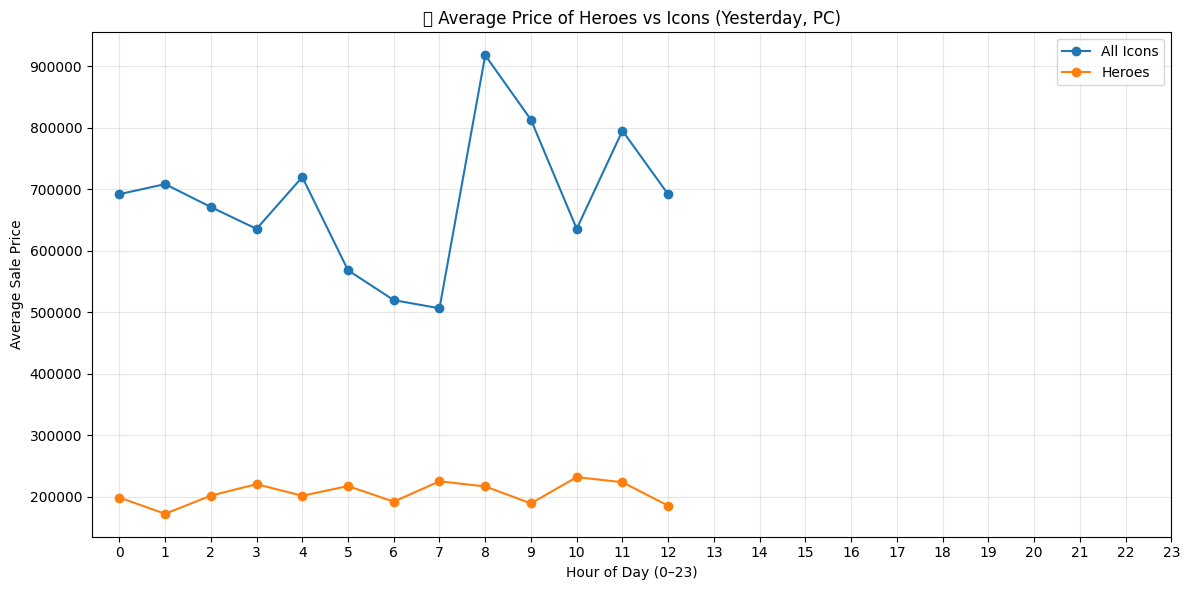

In [10]:
def plot_icons_and_heroes_yesterday(df, platform="pc"):
    # Find yesterday's date
    latest_time = df['sale_time'].max()
    yesterday = (latest_time - pd.Timedelta(days=0)).normalize()  # 00:00 of yesterday
    today = yesterday + pd.Timedelta(days=1)  # 00:00 of today
    
    # Filter only yesterday, platform, and versions
    mask = (
        (df['platform'] == platform) &
        (df['sold_price'] > 0) &
        (df['version'].isin(["All Icons", "Heroes"])) &
        (df['sale_time'] >= yesterday) &
        (df['sale_time'] < today)
    )
    sub_df = df[mask].copy()
    
    if sub_df.empty:
        print("No sales data found for yesterday.")
        return
    
    # Bucket by hour of yesterday
    sub_df['hour'] = sub_df['sale_time'].dt.hour
    
    # Group by hour + version
    grouped = sub_df.groupby(['hour', 'version'])['sold_price'].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    for version in grouped['version'].unique():
        data = grouped[grouped['version'] == version]
        plt.plot(data['hour'], data['sold_price'], marker='o', label=version)
    
    plt.title(f"📈 Average Price of Heroes vs Icons (Yesterday, {platform.upper()})")
    plt.xlabel("Hour of Day (0–23)")
    plt.ylabel("Average Sale Price")
    plt.xticks(range(0,24))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example
plot_icons_and_heroes_yesterday(df_26, platform="pc")

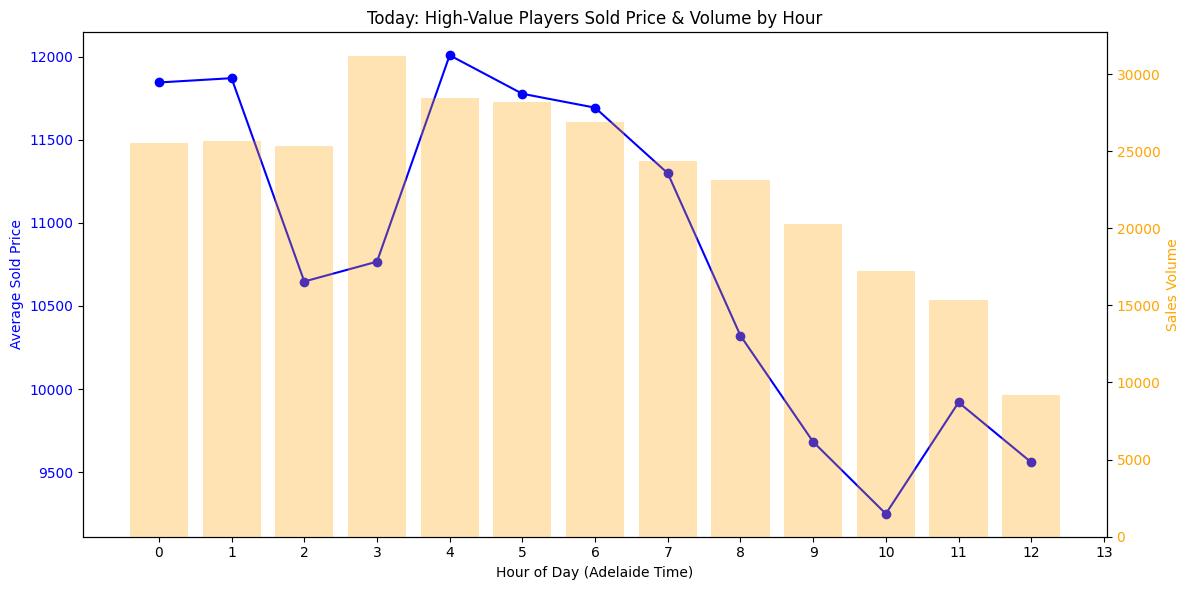

In [11]:
# Assuming df_26['sale_time'] is already in Adelaide timezone
adelaide_tz = df_26['sale_time'].dt.tz

# Yesterday's start and end
yesterday_start = pd.Timestamp.now(tz=adelaide_tz).normalize() - pd.Timedelta(days=0)
yesterday_end = yesterday_start + pd.Timedelta(days=1)

# Filter only yesterday
yesterday_df = df_26[
    (df_26['sale_time'] >= yesterday_start) &
    (df_26['sale_time'] < yesterday_end)
]



pc_yesterday_df = yesterday_df[(yesterday_df['platform'] == "pc")  & (yesterday_df['version'] == "Gold Rare")]


# Calculate hourly average sold price
hourly_stats = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour)['sold_price'].agg(['median','count']).reset_index()
hourly_stats = hourly_stats.sort_values('sale_time')

hourly_avg = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour)['sold_price'].mean().reset_index()
hourly_avg = hourly_avg.sort_values('sale_time')

# Group by hour
hourly = pc_yesterday_df.groupby(pc_yesterday_df['sale_time'].dt.hour).agg({
    'sold_price': 'mean',
    'name': 'count'  # count of sales as volume
}).reset_index().rename(columns={'name': 'sales_volume'})

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Sold price line
ax1.plot(hourly['sale_time'], hourly['sold_price'], color='blue', marker='o', label='Average Sold Price')
ax1.set_xlabel("Hour of Day (Adelaide Time)")
ax1.set_ylabel("Average Sold Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0,24))

# Volume bars
ax2 = ax1.twinx()
ax2.bar(hourly['sale_time'], hourly['sales_volume'], color='orange', alpha=0.3, label='Sales Volume')
ax2.set_ylabel("Sales Volume", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Today: High-Value Players Sold Price & Volume by Hour")
fig.tight_layout()
plt.show()

### BackTesting

In [12]:
import pandas as pd
from datetime import timedelta

# --- prepare data window & clean ---
df_26['sale_time'] = pd.to_datetime(df_26['sale_time'])
df_26 = df_26[df_26['platform'] == "pc"]
# window: yesterday -> today (you can change)
today = df_26['sale_time'].max().normalize()
yesterday = today - pd.Timedelta(days=4)
df_window = df_26[(df_26['sale_time'] >= yesterday) & (df_26['sale_time'] < today + pd.Timedelta(days=1))]


# clean obvious junk/outliers
def clean_group(g):
    g = g[g['sold_price'].notnull() & (g['sold_price'] > 200)]
    if len(g) < 10:
        return g
    low = g['sold_price'].quantile(0.05)
    high = g['sold_price'].quantile(0.95)
    return g[(g['sold_price'] >= low) & (g['sold_price'] <= high)]
df_clean = df_window.groupby('name', group_keys=False)\
                    .apply(clean_group)\
                    .reset_index(drop=True)

# compute per-card stats to use for checks
card_stats = df_clean.groupby('name')['sold_price'].agg(['median','max','quantile'])
# NOTE: .quantile here is not correct for groupby agg; we will compute 99th separately
q99 = df_clean.groupby('name')['sold_price'].quantile(0.99).rename('q99')
median = df_clean.groupby('name')['sold_price'].median().rename('median')
card_stats = pd.concat([median, q99], axis=1).fillna(0)

# --- Robust Backtester ---
class RobustBacktester:
    def __init__(self, df, tax=0.05, min_buy=200):
        self.df = df.sort_values('sale_time').reset_index(drop=True)
        self.tax = tax
        self.min_buy = min_buy
        self.trades = []
        self.suspicious = []

    def run_for_card(self, card_id, buy_rule, sell_rule):
        df = self.df[self.df['card_id'] == card_id].sort_values('sale_time').reset_index(drop=True)
        card_name = df['name'].iloc[0]
        trades = []
        for i, row in df.iterrows():
            # sell_price observed at row
            cur_sold = row['sold_price']
            # listed price may exist in your data
            listed = row.get('listed_price', None)
            signal, buy_price = buy_rule(df, i)

            # make buy decision ONLY from past (rows < i)
            if signal:
                # sanity: skip if buy_price <= min or obviously invalid
                if buy_price is None or buy_price <= self.min_buy:
                    continue

                trade = {
                    "card": df.loc[i, "name"],
                    "buy_time": df.loc[i, "sale_time"],      # ✅ same row as signal
                    "buy_price": buy_price,                    # ✅ from signal itself
                    "sell_time": None,
                    "sell_price": None,
                    "profit": None
                }
                trades.append(trade)


            else:
                # decide to sell
                if sell_rule(df, i, holding['buy_price']):
                    sell_price = cur_sold
                    net_sell = sell_price * (1 - self.tax)
                    profit = net_sell - holding['buy_price']
                    hold_hours = (row['sale_time'] - holding['buy_time']).total_seconds() / 3600.0

                    # sanity check: if sell_price > card 99th percentile by big margin, flag it
                    q99_price = card_stats.loc[card_name, 'q99'] if card_name in card_stats.index else None
                    if q99_price and sell_price > 1.5 * q99_price:
                        self.suspicious.append({
                            'card': card_name, 'buy_price': holding['buy_price'],
                            'sell_price': sell_price, 'sell_time': row['sale_time'],
                            'reason': 'sell >> q99'
                        })
                        # you can choose to skip adding this trade or add with flag.
                        # Here we still record but mark it
                        self.trades.append({'card':card_name,'buy_time':holding['buy_time'],
                                            'buy_price':holding['buy_price'],
                                            'sell_time':row['sale_time'],'sell_price':sell_price,
                                            'profit':profit,'hold_hours':hold_hours,'suspicious':True})
                    else:
                        self.trades.append({'card':card_name,'buy_time':holding['buy_time'],
                                            'buy_price':holding['buy_price'],
                                            'sell_time':row['sale_time'],'sell_price':sell_price,
                                            'profit':profit,'hold_hours':hold_hours,'suspicious':False})
                    holding = None

        return pd.DataFrame(self.trades), pd.DataFrame(self.suspicious)

# --- Example buy/sell rules (conservative) ---

def buy_rule_panic_dip(df, idx):
    if idx < 30:
        return False, None

    window = df.loc[max(0, idx-30):idx-1, 'sold_price']
    median_price = window.median()
    std_dev = window.std()
    cur = df.loc[idx, 'sold_price']

    if (
        pd.notnull(cur)
        and cur <= 0.85 * median_price
        and cur > 0.5 * median_price
        and std_dev / median_price < 0.08
    ):
        print("🔥 PANIC DIP BUY", df.loc[idx, 'sale_time'], cur, "vs median", median_price)
        return True, cur
    return False, None



def sell_rule_rebound(df, idx, buy_price):
    window = df.loc[max(0, idx-30):idx-1, 'sold_price']
    median_price = window.median()
    cur = df.loc[idx, 'sold_price']
    if pd.isnull(cur):
        return False
    # normal rebound sell
    if cur >= 0.97 * median_price:
        return True
    # stop-loss: cut if price falls another 10% from buy
    if cur <= 0.90 * buy_price:
        return True
    return False



# --- Run backtest for the suspicious card ---
bt = RobustBacktester(df_clean, tax=0.05, min_buy=200)
trades_df, suspicious_df = bt.run_for_card(1009, buy_rule_panic_dip, sell_rule_rebound)

print(trades_df.head(20))
print("Suspicious trades flagged:")
print(suspicious_df.head(20))
print("Total Profit:", trades_df['profit'].sum() if not trades_df.empty else 0.0)


C:\Users\shane\AppData\Local\Temp\ipykernel_8304\3533954825.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(clean_group)\


UnboundLocalError: cannot access local variable 'holding' where it is not associated with a value

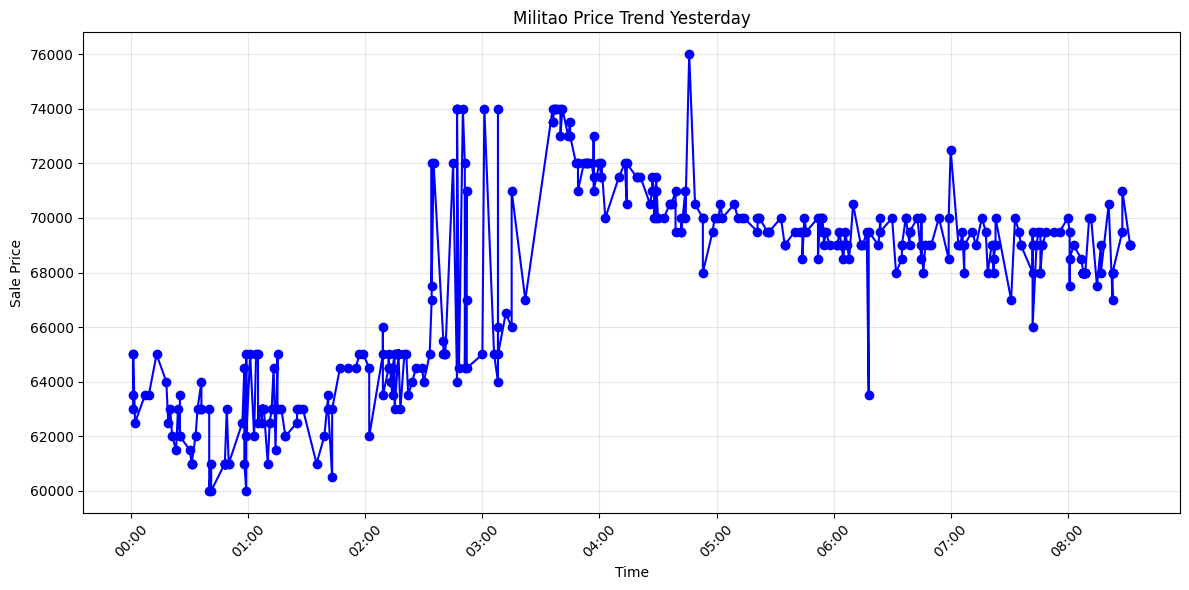

In [ ]:


def plot_militao_today(df, card_name="Militao"):
    # Filter for Militao and yesterday only
    today_start = pd.Timestamp.now().normalize() - pd.Timedelta(days=0)  # start of yesterday
    today_end = today_start + pd.Timedelta(days=1)

    player_df = df[
        (df['sold_price'] > 0) &
        (df['sold_price'] < 100000) &
        (df['name'].str.contains(card_name, case=False)) &
        (df['sale_time'] >= today_start) &
        (df['sale_time'] < today_end)
    ].sort_values('sale_time')

    if player_df.empty:
        print(f"No sales data for {card_name} yesterday.")
        return

    plt.figure(figsize=(12,6))
    plt.plot(player_df['sale_time'], player_df['sold_price'], marker='o', linestyle='-', color='blue')
    plt.title(f"{card_name} Price Trend Yesterday")
    plt.xlabel("Time")
    plt.ylabel("Sale Price")

    # Format x-axis to show only hour:minute
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
plot_militao_today(df_26, card_name="Militao")


C:\Users\shane\AppData\Local\Temp\ipykernel_8304\2305933341.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_week['hour'] = last_week['sale_time'].dt.hour
C:\Users\shane\AppData\Local\Temp\ipykernel_8304\2305933341.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shane\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


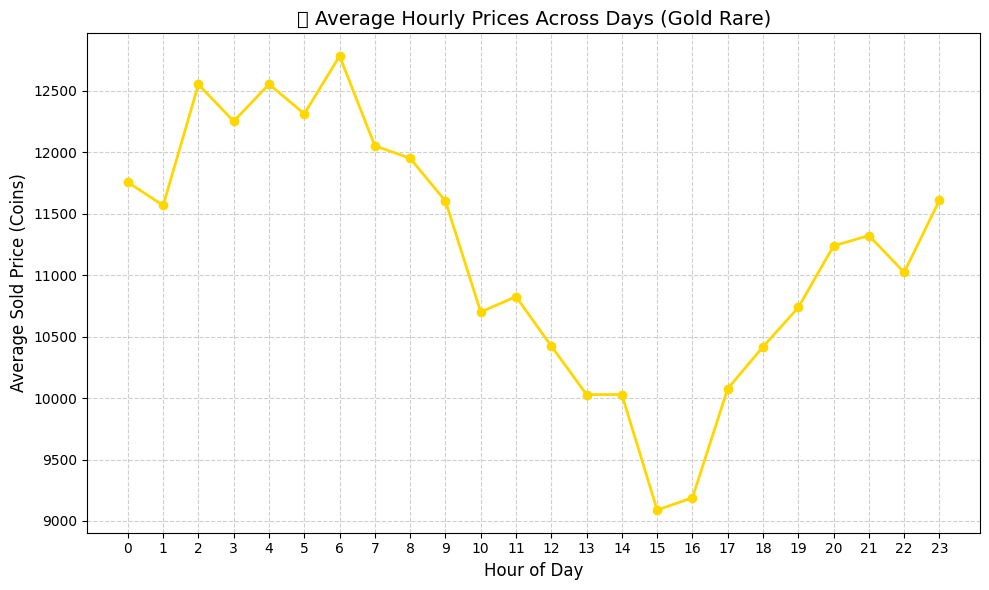

In [14]:
# Ensure datetime
df_26['sale_time'] = pd.to_datetime(df_26['sale_time'])

# Filter last 7 days and Gold Rare cards
last_week = df_26[
    (df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(days=7)) &
    (df_26['version'] == "Gold Rare")
]

# Extract hour of day
last_week['hour'] = last_week['sale_time'].dt.hour

# Group by hour and calculate average sold price
hourly_avg = last_week.groupby('hour')['sold_price'].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, color='gold')

# Labels
plt.title("📊 Average Hourly Prices Across Days (Gold Rare)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Sold Price (Coins)", fontsize=12)
plt.xticks(range(0,24))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\shane\AppData\Local\Temp\ipykernel_8304\2876976501.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_week['date'] = last_week['sale_time'].dt.date
C:\Users\shane\AppData\Local\Temp\ipykernel_8304\2876976501.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_week['hour'] = last_week['sale_time'].dt.hour
C:\Users\shane\AppData\Local\Temp\ipykernel_8304\2876976501.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shane\AppDa

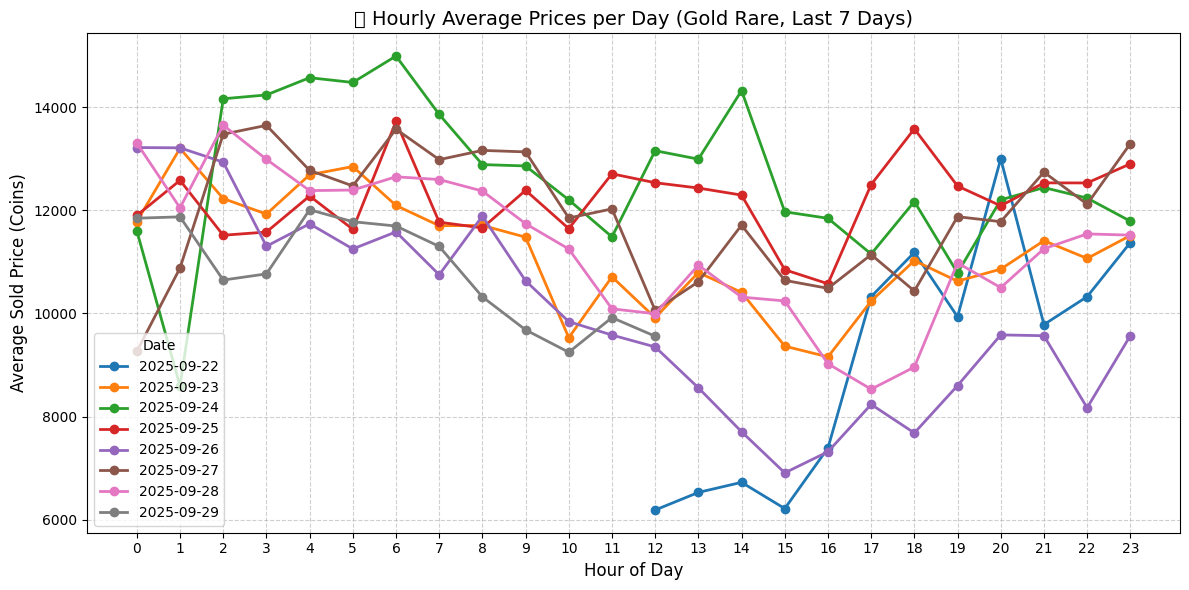

In [18]:

# Ensure datetime
df_26['sale_time'] = pd.to_datetime(df_26['sale_time'])

# Filter last 7 days and Gold Rare cards
last_week = df_26[
    (df_26['sale_time'] > df_26['sale_time'].max() - pd.Timedelta(days=7)) &
    (df_26['version'] == "Gold Rare")
]

# Extract date and hour
last_week['date'] = last_week['sale_time'].dt.date
last_week['hour'] = last_week['sale_time'].dt.hour

# Group by date and hour
hourly_by_day = last_week.groupby(['date', 'hour'])['sold_price'].mean().reset_index()

# Plot
plt.figure(figsize=(12,6))

for day in hourly_by_day['date'].unique():
    day_data = hourly_by_day[hourly_by_day['date'] == day]
    plt.plot(day_data['hour'], day_data['sold_price'], marker='o', linewidth=2, label=str(day))

# Labels
plt.title("📊 Hourly Average Prices per Day (Gold Rare, Last 7 Days)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Sold Price (Coins)", fontsize=12)
plt.xticks(range(0,24))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Date")
plt.tight_layout()
plt.show()
